In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy

torch.manual_seed(42)

## Two-Sample Test

We have two potential titles for a Youtube video. We want to see which one has a higher click-through-rate. 

- Title A: 98 views over 1000 impressions 

- Title B: 162 views over 2000 impressions 

We conduct a permutation test to test whether CTR for A ($\theta_A$) is equal to CTR for B ($\theta_B$).

$H_0: \theta_A=\theta_B, \quad H_1: \theta_A \neq \theta_B$.

Our test statistic is $|\hat{\theta}_A-\hat{\theta}_B|$.

In [19]:
my_viewsA = 98 # number of clicks for video A
my_viewsB = 162 # number of clicks for video B

n_impsA = 1000 # number of impressions for video A (total number of people who saw video title)
n_impsB = 2000 # number of impresssion for video B

Dataset A: $(1, \dots, 1, 0, 0, \dots, 0)$ (98 ones, 902 zeros)

Dataset B: $(1,\dots, 1, 0, \dots, 0)$ (162 ones, 1838 zeros)

In [20]:
my_viewsA/n_impsA

0.098

In [21]:
my_viewsB/n_impsB

0.081

In [22]:
obs_T = abs(my_viewsA/n_impsA - my_viewsB/n_impsB) # |theta_1 - theta_2|

In [23]:
obs_T

0.017

We pool the Dataset A and Dataset B. (We will shuffle Dataset A and Dataset B in the permutation test).

In [24]:
all_views = my_viewsA + my_viewsB
all_imps = n_impsA + n_impsB
pool = np.array([1]*all_views + [0]*(all_imps - all_views))

Here is an example of a random draw from the null distribution (that the CTR of A and B is the same).

In [25]:
# Sample without replacement for impsA
impsA = np.random.choice(pool, n_impsA, replace=False)
# new permuted dataset of size n_impsA
viewsA = np.sum(impsA)
viewsB = all_views - viewsA

Permutation test:

- draw 500 samples from null distribution
- for each sample $s=1,\dots, 500$, calculate $T_s = |\hat{\theta}_{A, s}-\hat{\theta}_{B, s}|$
- locate actual observed $T_{obs}=|\hat{\theta}_A-\hat{\theta}_B|$ in sample distribution:
$$\text{p-val} = \frac{1}{S}\sum_{s=1}^{500} \mathbb{1}(T_s\geq T_{obs} )$$

P-Value: 0.1480


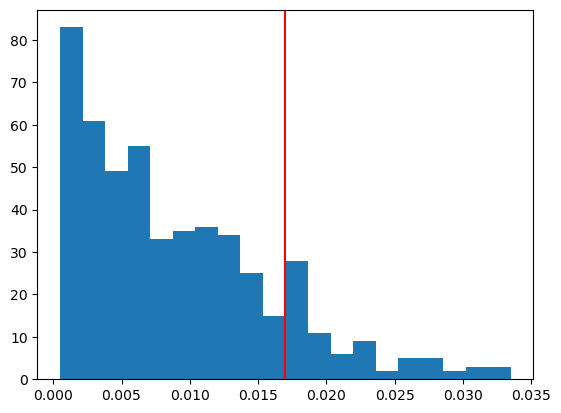

In [26]:
n_perm = 500
resampled_Ts = np.zeros(n_perm) # where to store our permutation test statistics

for cur_sim in range(n_perm):
    # Pool with 1s for views and 0s for non-views
    pool = np.array([1]*all_views + [0]*(all_imps - all_views))
    # create an array with (98+162) ones and (1000+2000 - 98-162) zeros
    
    # (1, 1, 1, 1, ..., 1, 0, 0, 0, ..., 0) (1, 1,.., 1, 0, 0, 0, 0, ...,0)
    # (1, 1, 0, 0, 0, 1, ..., 0, 1, 0, )

    # Sample without replacement for impsA
    impsA = np.random.choice(pool, n_impsA, replace=False)
    # new permuted dataset of size n_impsA
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA
    
    resampled_Ts[cur_sim] = abs(viewsA/n_impsA - viewsB/n_impsB) # | theta_1 -theta_2| for this dataset

p_value = sum([1 for t in resampled_Ts if t >= obs_T]) / n_perm

print(f"P-Value: {p_value:.4f}")

plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()

Conclusion: we retain the null hypothesis. 

## Independence test with neural networks

Data: $(X_1,Y_1), (X_2, Y_2),\dots, (X_n, Y_n)$

We consider two different methods to conduct an independence test:

$H_0: X \text{ is independent of } Y \text{ vs. } H_1: X, Y \text{ not independent}$


### Method 1

- Generate 500 random permutations $(X_1, Y_{\pi(1)}),\dots, (X_n, Y_{\pi(n)})$
- For each permutation:
    - Split into train/test
    - Train neural network on train data
    - Calculate error on test data ($T_s$)
- For actual data:
    - Split into train/test
    - Train neural network on train data
    - Calculate error on test data ($T_{obs}$)
- Calculate $p$-value:
$$\text{p-val} = \frac{1}{S}\sum_{s=1}^{500} \mathbb{1}(T_s\geq T_{obs} )$$

In [27]:
class NNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim))

    def forward(self, x):
        return self.sequential(x)

We create simulated data which we know is NOT independent.

Ideally, we should reject the null hypothesis that $Y$ and $X$ are independent.

In [28]:
p1 = 5 # dimension of X
p2 = 3 # dimension of Y

signal_strength = 0.2

n_samples = 10000

X = np.random.randn(n_samples, p1)

B = np.random.randn(p2, p1)
B = B / np.linalg.norm(B, ord='fro') # some parameter

Y = signal_strength * X @ B.T + np.random.randn(n_samples, p2)
# Y = B X + random noise

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [29]:
def testerr(x, y, epochs=100):

    # trains a neural network to predict y from x
    ntrain = int(n_samples * 0.7) # train on 70% of the data
    ntest = n_samples - ntrain

    x_train = x[:ntrain]
    x_test = x[ntrain:]

    y_train = y[:ntrain]
    y_test = y[ntrain:]

    net = NNet(p1, p2)

    optimizer = optim.Adam(net.parameters(), lr=0.2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(x_train)
        
        loss = nn.MSELoss(reduction='mean')(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    outputs = net(x_test)
    loss = nn.MSELoss(reduction='mean')(outputs, y_test)

    return loss.item()

# our observed test statistic is the loss in predicting y from x
obs_T = testerr(X, Y)

In [30]:
obs_T

1.0047097206115723

In [31]:
# Perform permutation testing
n_permutations = 500
resampled_Ts = []

for _ in range(n_permutations):
    permuted_Y = Y[torch.randperm(n_samples)]
    resampled_T = testerr(X, permuted_Y) # train a neural network, output training loss
    resampled_Ts.append(resampled_T)

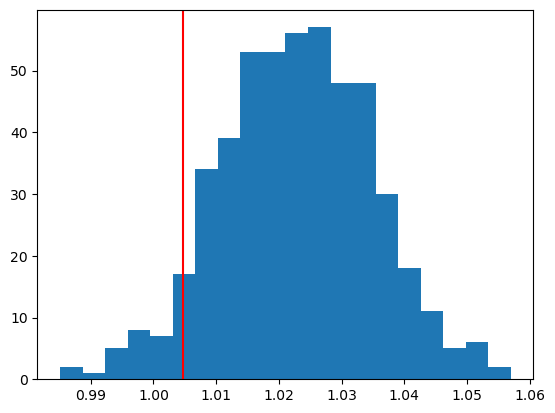

Observed test statistic: 1.0047
P-Value: 0.0580


In [32]:
# Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

# plot distribution of permuted_test_statistics
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()


print(f"Observed test statistic: {obs_T:.4f}")
print(f"P-Value: {p_value:.4f}")

### Method 2

- Split into train and test data
- Train $f$ to predict $Y$ from $X$
- Train baseline $f_{base}$ to predict $Y$ (this is $\bar{Y}$)
- For each datapoint, compute error:
$$z_i = Loss(f(x_i), y_i),\quad \widetilde{z}_i=Loss(f_{base}, y_i)$$
- For $s=1,\dots, 500$:
    - Switch $z_i$ and $\widetilde{z}_i$ with probability 0.5
    - Calculate mean($z_{i,s}$) - mean($\widetilde{z}_{i,s}$)
- For observed data:
    - Calculate mean($z_i$) - mean($\widetilde{z}_i$)
- Calculate $p$-value

In [33]:
## sample split
ntrain = int(n_samples * 0.7) # train on 70% of the data
ntest = n_samples - ntrain

X_train = X[:ntrain]
X_test = X[ntrain:]

Y_train = Y[:ntrain]
Y_test = Y[ntrain:]

net = NNet(p1, p2)

Y_train_centered = Y_train - torch.mean(Y_train, dim=0)

In [34]:
epochs = 200
optimizer = optim.SGD(net.parameters(), lr=.1)
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(X_train)
        
    loss = nn.MSELoss(reduction='mean')(outputs, Y_train_centered)
    loss.backward()
    optimizer.step()

testerrs = torch.sum((Y_test - net(X_test) - torch.mean(Y_train, dim=0))**2, dim=1)
mean_testerr = torch.mean(testerrs)

In [35]:
testerrs

tensor([2.5163, 8.0750, 1.9151,  ..., 7.1741, 0.8597, 3.6098],
       grad_fn=<SumBackward1>)

In [36]:
nullerrs = torch.sum((Y_test - torch.mean(Y_train, dim=0))**2, dim=1)
mean_nullerr = torch.mean( nullerrs )

In [37]:
nullerrs

tensor([2.2313, 7.9352, 1.9563,  ..., 7.6444, 0.8521, 3.3415])

In [38]:
print(f"Mean Test Errors: {mean_testerr:.4f}")
print(f"Mean Null Test Errors: {mean_nullerr:.4f}")

obs_T = mean_testerr - mean_nullerr

Mean Test Errors: 2.9884
Mean Null Test Errors: 3.0283


In [39]:
combined = torch.stack((testerrs, nullerrs), dim=1)

In [41]:
heads = torch.randint(0, 2, (ntest,))

resampled_testerrs = combined[torch.arange(ntest), heads]
resampled_nullerrs = combined[torch.arange(ntest), 1-heads]

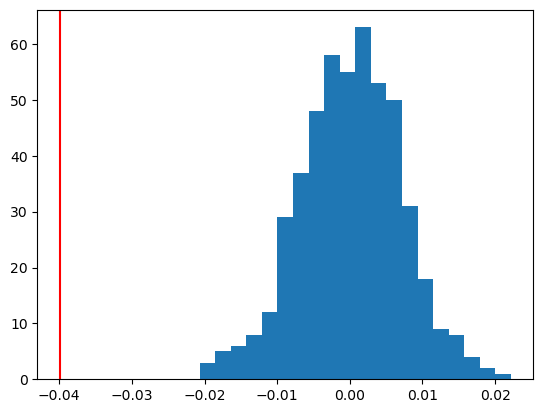

P-Value: 0.0000


In [42]:
n_permutations = 500
resampled_Ts = []

for _ in range(n_permutations):
    heads = torch.randint(0, 2, (ntest,))

    resampled_testerrs = combined[torch.arange(ntest), heads]
    resampled_nullerrs = combined[torch.arange(ntest), 1-heads]
    # test error using X - test error not using X
    resampled_T = torch.mean(resampled_testerrs) - torch.mean(resampled_nullerrs)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

resampled_Ts = [t.detach().numpy() for t in resampled_Ts]
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T.detach().numpy(), color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")
